In [31]:
%env THEANO_FLAGS=device=cpu,floatX=float32

env: THEANO_FLAGS=device=cpu,floatX=float32


In [32]:
from matplotlib import pyplot as plt
%matplotlib inline

DeepLarning Couse CSC: 
* Arseniy Ashuha, you can text me ```ars.ashuha@gmail.com```,
* Denis Kharchenko (HSE student)
* ```https://vk.com/ars.ashuha``` 
* partially reusing https://github.com/ebenolson/pydata2015

<h1 align="center"> Image Captioning </h1> 

In this seminar you'll be going through the image captioning pipeline.

To begin with, let us download the dataset of image features from a pre-trained GoogleNet.



In [33]:
!wget https://www.dropbox.com/s/3hj16b0fj6yw7cc/data.tar.gz?dl=1 -O data.tar.gz
!tar -xvzf data.tar.gz

--2017-02-03 16:17:20--  https://www.dropbox.com/s/3hj16b0fj6yw7cc/data.tar.gz?dl=1
Resolving www.dropbox.com... 162.125.66.1
Connecting to www.dropbox.com|162.125.66.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/yhkAoWRY9LSivUhYhYkYj9El5LkhFJ3vcoBt7FBWleHiTkVamWTUS5cH94XqmkQE/file?dl=1 [following]
--2017-02-03 16:17:20--  https://dl.dropboxusercontent.com/content_link/yhkAoWRY9LSivUhYhYkYj9El5LkhFJ3vcoBt7FBWleHiTkVamWTUS5cH94XqmkQE/file?dl=1
Resolving dl.dropboxusercontent.com... 162.125.66.6
Connecting to dl.dropboxusercontent.com|162.125.66.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 506221998 (483M) [application/octet-stream]
Saving to: “data.tar.gz”

100%[======================================>] 506,221,998 16.6M/s   in 33s     

2017-02-03 16:17:54 (14.7 MB/s) - “data.tar.gz” saved [506221998/506221998]

data/caption_tokens.pcl
data/
data/image_codes.npy
data/raw_capt

### Data preprocessing

In [34]:
%%time
# Read Dataset
import numpy as np
import pickle

img_codes = np.load("data/image_codes.npy")
captions = pickle.load(open('data/caption_tokens.pcl', 'rb'))

CPU times: user 721 ms, sys: 493 ms, total: 1.21 s
Wall time: 1.21 s


In [35]:
print "each image code is a 1000-unit vector:", img_codes.shape
print img_codes[0,:10]
print '\n\n'
print "for each image there are 5-7 descriptions, e.g.:\n"
print '\n'.join(captions[0])

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-35-d74b4ffc2a5c>, line 1)

In [36]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

In [37]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()
for img_captions in captions:
    for caption in img_captions:
        word_counts.update(caption)

In [38]:
vocab  = ['#UNK#', '#START#', '#END#']
vocab += [k for k, v in word_counts.items() if v >= 5]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [39]:
PAD_ix = -1
UNK_ix = vocab.index('#UNK#')

#good old as_matrix for the third time
def as_matrix(sequences,max_len=None):
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences),max_len),dtype='int32')+PAD_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word,UNK_ix) for word in seq[:max_len]]
        matrix[i,:len(row_ix)] = row_ix
    
    return matrix

In [40]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[ 8766,  7866,  3421,  3072,  5623, 10354,  6580,  1153,   149,
         5514,  1249,  8282,  7282,    -1,    -1],
       [ 8766,   149,  5514,  1802,  6800,  7556,  8282,  1249,  5001,
         1933,  6580,  7282,    -1,    -1,    -1],
       [ 8766,  4304,  3072,  5623, 10354,  6580,  1153,   149,  8303,
         1003,  7428,  9901,  7369,  3677,  7282],
       [ 8766,  4304,  4955,  2549,  5670,  4810,  4304,  4955,  6483,
         7282,    -1,    -1,    -1,    -1,    -1],
       [ 8766,  7866,  3421,  3072,  5623, 10354,  6580,  1153,   149,
         5514,  7428,  9901,  3104,  7282,    -1]], dtype=int32)

### Mah Neural Network

In [41]:
# network shapes. 
CNN_FEATURE_SIZE = img_codes.shape[1]
EMBED_SIZE = 128 #pls change me if u want
LSTM_UNITS = 200 #pls change me if u want

In [42]:
import theano
import theano.tensor as T

In [43]:
# Input Variable
sentences = T.imatrix()# [batch_size x time] of word ids
image_vectors = T.matrix() # [batch size x unit] of CNN image features
sentence_mask = T.neq(sentences,PAD_ix)

In [44]:
import lasagne
from lasagne.layers import *

In [45]:
#network inputs
l_words = InputLayer((None,None),sentences )
l_mask = InputLayer((None,None),sentence_mask)

#embeddings for words 
l_word_embeddings = EmbeddingLayer(l_words,n_tokens,EMBED_SIZE)

#cudos for using some pre-trained embedding :)

In [46]:
# input layer for image features
l_image_features = InputLayer((None,CNN_FEATURE_SIZE),image_vectors)

#convert 1000 image features from googlenet to whatever LSTM_UNITS you have set
#it's also a good idea to add some dropout here and there
l_image_features_small = DropoutLayer(l_image_features,0.5)
l_image_features_small = DenseLayer(l_image_features_small, LSTM_UNITS)
assert l_image_features_small.output_shape == (None,LSTM_UNITS)

In [47]:
# Concatinate image features and word embedings in one sequence 
decoder = LSTMLayer(l_word_embeddings,
                    num_units=LSTM_UNITS,
                    cell_init=l_image_features_small,
                    mask_input=l_mask,
                    grad_clipping=5)

#find out better recurrent architectures for bonus point

In [48]:
# Decoding of rnn hiden states
from broadcast import BroadcastLayer,UnbroadcastLayer

#apply whatever comes next to each tick of each example in a batch. Equivalent to 2 reshapes
broadcast_decoder_ticks = BroadcastLayer(decoder,(0,1))
print ("broadcasted decoder shape = ",broadcast_decoder_ticks.output_shape)

broadcasted decoder shape =  (None, 200)


In [49]:
#predict probabilities for next tokens
predicted_probabilities_each_tick = DenseLayer(broadcast_decoder_ticks,n_tokens,
                                               nonlinearity=lasagne.nonlinearities.softmax)
# maybe a more complicated architecture will work better?

In [50]:
#un-broadcast back into (batch,tick,probabilities)
predicted_probabilities = UnbroadcastLayer(predicted_probabilities_each_tick,
                                           broadcast_layer=broadcast_decoder_ticks)

print ("output shape = ",predicted_probabilities.output_shape)

#remove if you know what you're doing (e.g. 1d convolutions or fixed shape)
assert predicted_probabilities.output_shape == (None, None, 10373)

output shape =  (None, None, 10373)


### Some tricks
* If you train large network, it is usually a good idea to make a 2-stage prediction
    1. (large recurrent state) -> (bottleneck e.g. 256)
    2. (bottleneck) -> (vocabulary size)
    * this way you won't need to store/train (large_recurrent_state x vocabulary size) matrix
* Also maybe use Hierarchical Softmax?
    * https://gist.github.com/justheuristic/581853c6d6b87eae9669297c2fb1052d




In [51]:
next_word_probas = get_output(predicted_probabilities)

reference_answers = sentences[:,1:]
output_mask = sentence_mask[:,1:]

#write symbolic loss function to train NN for
loss = lasagne.objectives.categorical_crossentropy(
    next_word_probas[:,:-1].reshape((-1,n_tokens)),
    reference_answers.reshape((-1,))).reshape(reference_answers.shape)

#mean over non-PAD tokens
loss = (loss*output_mask).sum() / output_mask.sum()

In [52]:
#trainable NN weights
weights = get_all_params(predicted_probabilities,trainable=True)
updates = lasagne.updates.adam(loss,weights)

In [53]:
#compile a functions for training and evaluation
#please not that your functions must accept image features as FIRST param and sentences as second one
train_step = theano.function([image_vectors,sentences],loss,updates=updates)
val_step   = theano.function([image_vectors,sentences],loss)
#for val_step use deterministic=True if you have any dropout/noize

ERROR (theano.gof.opt): Optimization failure due to: constant_folding
ERROR (theano.gof.opt): node: Elemwise{Cast{float32}}(TensorConstant{(1, 1) of 0})
ERROR (theano.gof.opt): TRACEBACK:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/homeappl/home/mohakala/.local/lib/python3.4/site-packages/theano/gof/opt.py", line 1964, in process_node
    replacements = lopt.transform(node)
  File "/homeappl/home/mohakala/.local/lib/python3.4/site-packages/theano/tensor/opt.py", line 6441, in constant_folding
    no_recycling=[], impl=impl)
  File "/homeappl/home/mohakala/.local/lib/python3.4/site-packages/theano/gof/op.py", line 924, in make_thunk
    no_recycling)
  File "/homeappl/home/mohakala/.local/lib/python3.4/site-packages/theano/gof/op.py", line 828, in make_c_thunk
    output_storage=node_output_storage)
  File "/homeappl/home/mohakala/.local/lib/python3.4/site-packages/theano/gof/cc.py", line 1190, in make_thunk
    keep_lock=keep_lock)
  File "/homeappl/home/mohakal

ImportError: /homeappl/home/mohakala/.theano/compiledir_Linux-2.6-el6.x86_64-x86_64-with-centos-6.8-Final-x86_64-3.4.5-64/tmpl0jwknez/m45344e52ad8941a69f1d2c0ee2f792a2.so: unsupported version 0 of Verneed record


# Training

* You first have to implement a batch generator
* Than the network will get trained the usual way

In [22]:
captions = np.array(captions)

In [24]:
from random import choice

def generate_batch(images,captions,batch_size,max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0,len(images),size=batch_size)
    
    #get images
    batch_images = images[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick 1 from 5-7 captions for each image
    batch_captions = map(choice,captions_for_batch_images)
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return batch_images, batch_captions_ix

In [25]:
generate_batch(img_codes,captions,3)

(array([[  5.32574558,  -5.69166756,  -5.24139547, ...,   5.00665522,
          12.90476131,  -3.49084949],
        [ -0.50686502,  -4.96793318,  -0.48227108, ...,  -0.05813873,
          -0.79627573,  -1.93483412],
        [ -6.54528141,  -4.53665066,   2.3325305 , ...,  -4.06876087,
          -2.51112509,   7.25116777]], dtype=float32),
 array([[8481, 8717, 4431, 4859, 3180, 3221, 3017,  326, 7471, 1225, 3980,
          603, 8134],
        [8481, 2171, 8902, 8797, 2665,  595, 3323, 6267, 3980, 3323, 7829,
         1926, 8134],
        [8481, 8797, 1380, 9811, 3980, 2879,  781, 3323, 3400, 8134,   -1,
           -1,   -1]], dtype=int32))

### Main loop
* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again

In [26]:
batch_size=50 #adjust me
n_epochs=100 #adjust me
n_batches_per_epoch = 50 #adjust me
n_validation_batches = 5 #how many batches are used for validation after each epoch

In [32]:
from tqdm import tqdm

for epoch in range(n_epochs):
    
    train_loss=0
    for _ in tqdm(range(n_batches_per_epoch)):
        train_loss += train_step(*generate_batch(img_codes,captions,batch_size))
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    for _ in range(n_validation_batches):
        val_loss += val_step(*generate_batch(img_codes,captions,batch_size))
    val_loss /= n_validation_batches
    
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finish :)")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0, train loss: 5.7587326838, val loss: 5.39070457535


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1, train loss: 5.27002072874, val loss: 5.0482680501


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 2, train loss: 5.02681008993, val loss: 4.91233599545


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 3, train loss: 4.7805464951, val loss: 4.80043693544


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 4, train loss: 4.63476094514, val loss: 4.51297349915


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 5, train loss: 4.46731769065, val loss: 4.28180817792


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 6, train loss: 4.32713453265, val loss: 4.16080257415


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 7, train loss: 4.21593307294, val loss: 4.16831085453


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 8, train loss: 4.08683116064, val loss: 4.10337110757


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 9, train loss: 3.97807988047, val loss: 4.03535025954


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 10, train loss: 3.95938113724, val loss: 3.83990561936


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 11, train loss: 3.87501409014, val loss: 3.99508262141


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 12, train loss: 3.84128357205, val loss: 3.76216253625


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 13, train loss: 3.73262090026, val loss: 3.79901571038


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 14, train loss: 3.71597415891, val loss: 3.7540122708


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 15, train loss: 3.69279154747, val loss: 3.60744140465


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 16, train loss: 3.62739071543, val loss: 3.61870205083


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 17, train loss: 3.61646099698, val loss: 3.68362431192


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 18, train loss: 3.52431811221, val loss: 3.50350308201


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 19, train loss: 3.52734543642, val loss: 3.47247906191


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 20, train loss: 3.52415836754, val loss: 3.33296230862


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 21, train loss: 3.45496154673, val loss: 3.50627081976


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 22, train loss: 3.41769106296, val loss: 3.35153063783


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 23, train loss: 3.43413570245, val loss: 3.31217033659


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 24, train loss: 3.38967105084, val loss: 3.49437767925


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 25, train loss: 3.37137081765, val loss: 3.43222064075


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 26, train loss: 3.41239455378, val loss: 3.34837975976


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 27, train loss: 3.31783648126, val loss: 3.30862287224


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 28, train loss: 3.31824944695, val loss: 3.25663012891


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 29, train loss: 3.3211537018, val loss: 3.34517936605


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 30, train loss: 3.27127772205, val loss: 3.40995247844


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 31, train loss: 3.27130160378, val loss: 3.33521301696


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 32, train loss: 3.23613522016, val loss: 3.21076032631


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 33, train loss: 3.24053341711, val loss: 3.14959610644


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 34, train loss: 3.20813904524, val loss: 3.15626308271


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 35, train loss: 3.21621979284, val loss: 3.29342394935


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 36, train loss: 3.16953362879, val loss: 3.24314817856


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 37, train loss: 3.20314482007, val loss: 3.16135311855


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 38, train loss: 3.17859327085, val loss: 3.10517620798


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 39, train loss: 3.16568234455, val loss: 3.07097300605


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 40, train loss: 3.16344517104, val loss: 3.11959680103


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 41, train loss: 3.16252036055, val loss: 3.16459401102


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 42, train loss: 3.19466937058, val loss: 3.1866100705


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 43, train loss: 3.13178970385, val loss: 3.11185521089


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 44, train loss: 3.10142572211, val loss: 2.98269131498


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 45, train loss: 3.09183569871, val loss: 2.97471476141


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 46, train loss: 3.10469818343, val loss: 3.1293604954


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 47, train loss: 3.07728486337, val loss: 3.14628498387


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 48, train loss: 3.07919444003, val loss: 3.12879278664


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 49, train loss: 3.09445429537, val loss: 3.12060649907


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 50, train loss: 3.04888193141, val loss: 2.97315092761


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 51, train loss: 3.06564383168, val loss: 3.04034388642


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 52, train loss: 3.06519015572, val loss: 3.05131603312


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 53, train loss: 3.03774925434, val loss: 3.07900004495


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 54, train loss: 3.0617030012, val loss: 3.10142505382


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 55, train loss: 3.03468456234, val loss: 3.1470557546


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 56, train loss: 3.02793156072, val loss: 3.05014586492


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 57, train loss: 3.03246362404, val loss: 3.03984600428


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 58, train loss: 3.0144427204, val loss: 3.00405719738


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 59, train loss: 3.04508717423, val loss: 3.00208080198


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 60, train loss: 3.01431274134, val loss: 2.95272505113


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 61, train loss: 2.98297225052, val loss: 3.14995071437


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 62, train loss: 3.00139768964, val loss: 3.16378069335


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 63, train loss: 3.00094490523, val loss: 2.83317511171


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 64, train loss: 2.98425008422, val loss: 2.96354132218


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 65, train loss: 2.99585816614, val loss: 2.91977774079


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 66, train loss: 2.99570946995, val loss: 3.03922985714


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 67, train loss: 2.96972526309, val loss: 3.05238228687


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 68, train loss: 2.95535556859, val loss: 2.95586463963


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 69, train loss: 2.96352836461, val loss: 3.03961974671


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 70, train loss: 2.95079554963, val loss: 2.99653589105


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 71, train loss: 2.95941170952, val loss: 2.97393931588


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 72, train loss: 2.93218021042, val loss: 2.85572637659


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 73, train loss: 2.95401853488, val loss: 3.00129546349


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 74, train loss: 2.92265204114, val loss: 2.85281729643


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 75, train loss: 2.9212464798, val loss: 2.93093408773


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 76, train loss: 2.90740499958, val loss: 2.94818977471


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 77, train loss: 2.92528355356, val loss: 3.02477884221


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 78, train loss: 2.91010287967, val loss: 2.94451851013


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 79, train loss: 2.91821751287, val loss: 3.07516513874


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 80, train loss: 2.88636070948, val loss: 2.96845799623


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 81, train loss: 2.93654633961, val loss: 2.8559737383


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 82, train loss: 2.94053631804, val loss: 2.91733907083


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 83, train loss: 2.86890572922, val loss: 3.01658379276


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 84, train loss: 2.91030326549, val loss: 2.91189357345


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 85, train loss: 2.85188760758, val loss: 2.84734809774


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 86, train loss: 2.87817909066, val loss: 2.9431707224


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 87, train loss: 2.87269855677, val loss: 2.87513698761


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 88, train loss: 2.88458466245, val loss: 2.87322244544


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 89, train loss: 2.88333318858, val loss: 2.78994829902


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 90, train loss: 2.85971331084, val loss: 2.91245753879


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 91, train loss: 2.86006065289, val loss: 2.97581406277


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 92, train loss: 2.84451740613, val loss: 2.98136133638


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 93, train loss: 2.85180709275, val loss: 2.92928901998


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 94, train loss: 2.84257354851, val loss: 2.7645592495


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 95, train loss: 2.8791304636, val loss: 2.81369385864


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 96, train loss: 2.84516683601, val loss: 2.87415795364


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 97, train loss: 2.85938385555, val loss: 2.89134244432


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 98, train loss: 2.83787675459, val loss: 2.77742166568


100%|██████████| 50/50 [02:39<00:00,  2.99s/it]


Epoch: 99, train loss: 2.83510164951, val loss: 2.77828283223
Finish :)


### apply trained model

In [33]:
#the same kind you did last week, but a bit smaller
from pretrained_lenet import build_model,preprocess,MEAN_VALUES

# build googlenet
lenet = build_model()

#load weights
lenet_weights = pickle.load(open('data/blvc_googlenet.pkl'))['param values']
set_all_param_values(lenet["prob"], lenet_weights)

#compile get_features
cnn_input_var = lenet['input'].input_var
cnn_feature_layer = lenet['loss3/classifier']
get_cnn_features = theano.function([cnn_input_var], lasagne.layers.get_output(cnn_feature_layer))

## Generate caption

In [199]:
last_word_probas = get_output(predicted_probabilities,deterministic=True)[:,-1]
#TRY OUT deterministic=True if you want more steady results

get_probs = theano.function([image_vectors,sentences], last_word_probas)

#this is exactly the generation function from week5 classwork,
#except now we condition on image features instead of words
def generate_caption(image,caption_prefix = ("START",),t=1,sample=True,max_len=100):
    image_features = get_cnn_features(image)
    caption = list(caption_prefix)
    for _ in range(max_len):
        
        next_word_probs = get_probs(image_features,as_matrix([caption])).ravel()
        assert len(next_word_probs.shape) ==1 #must be one-dimensional
        #apply temperature
        next_word_probs = next_word_probs**t / np.sum(next_word_probs**t)

        if sample:
            next_word = np.random.choice(vocab,p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption.append(next_word)

        if next_word=="#END#":
            break
            
    return caption

### Good examples

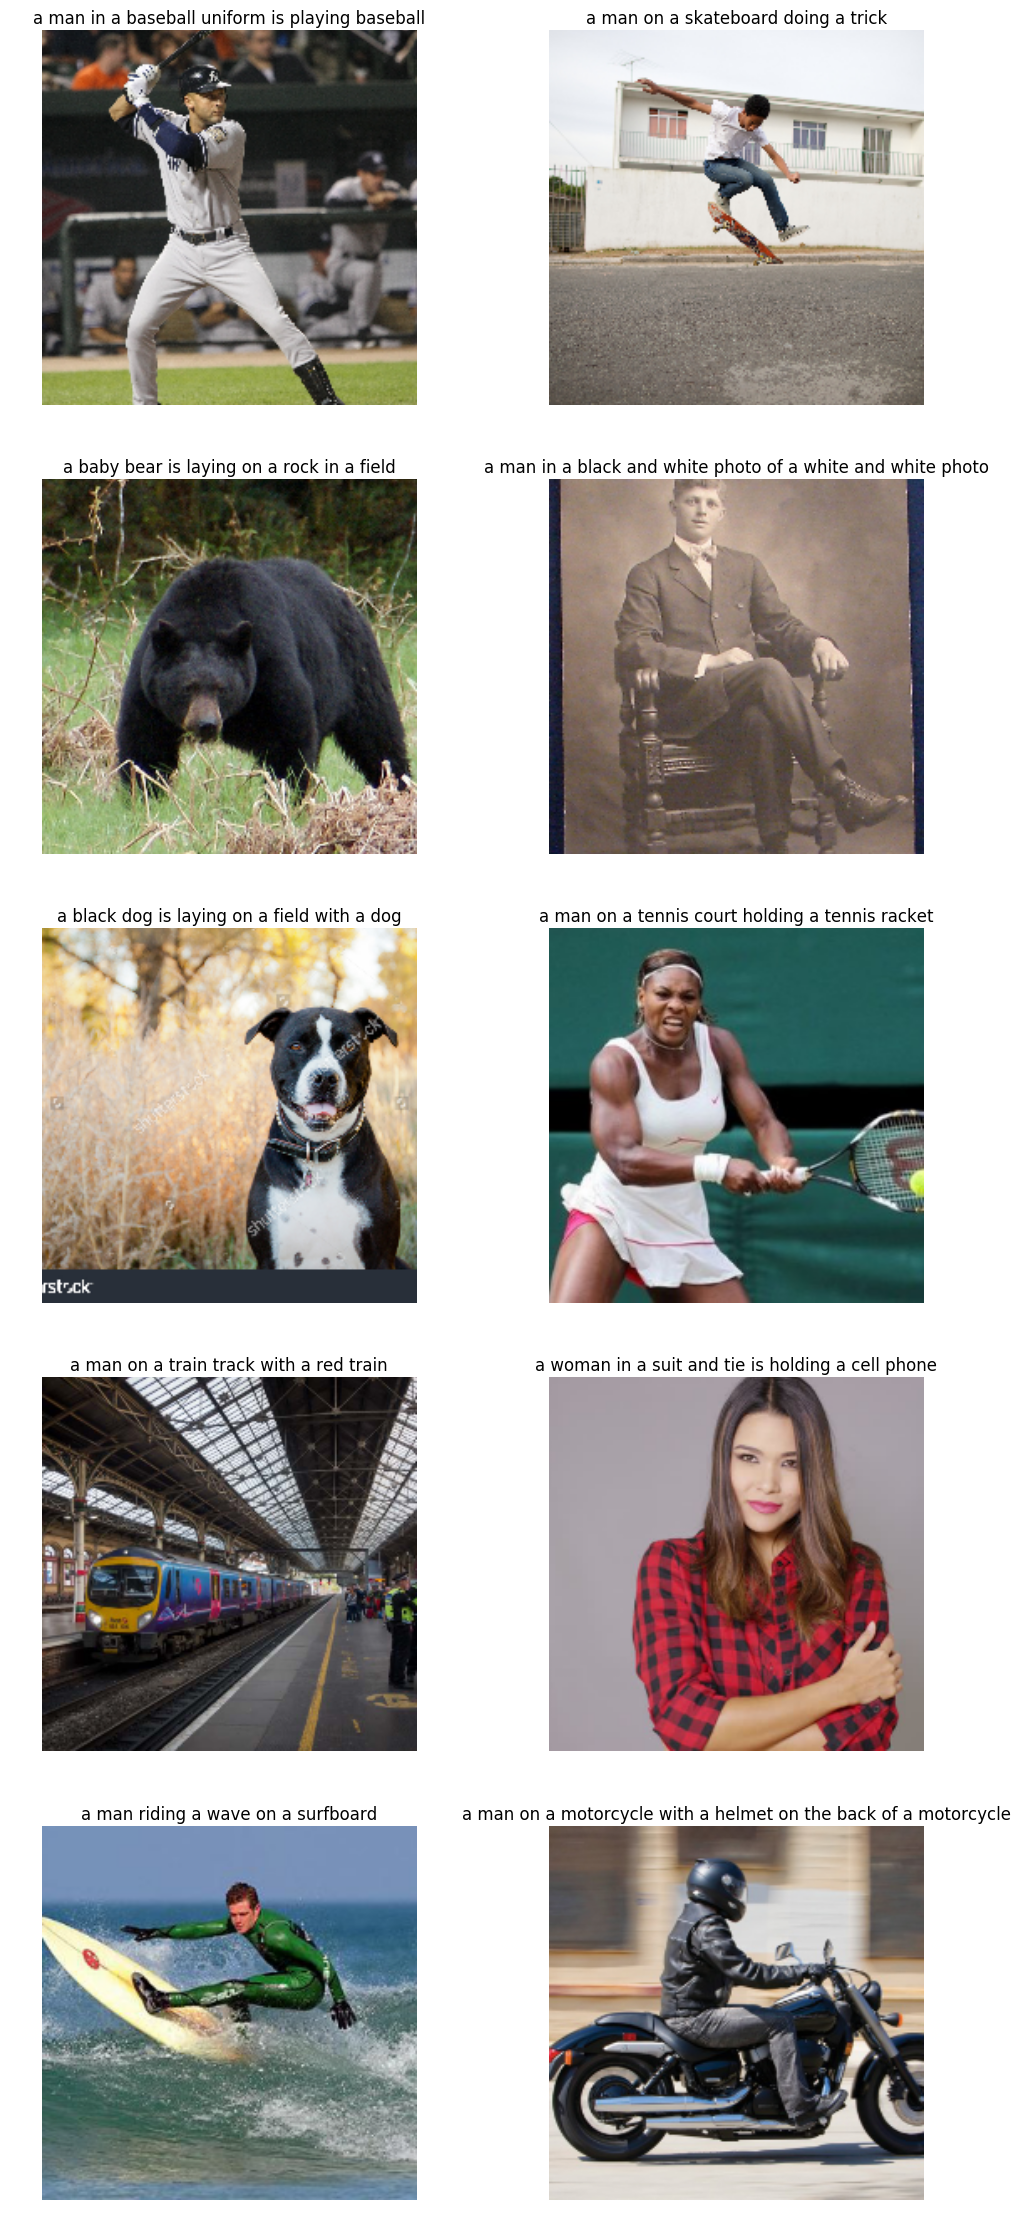

In [203]:
plt.figure(figsize=(12,28))
for i in range(10):
    img = plt.imread('good/img'+str(i+1)+'.jpg')
    img = preprocess(img)
    txt = ' '.join(generate_caption(img,t=5.,sample=False)[1:-1])
    plt.subplot(5,2,i+1)
    plt.axis('off')
    plt.title(txt)
    plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

### Fail examples

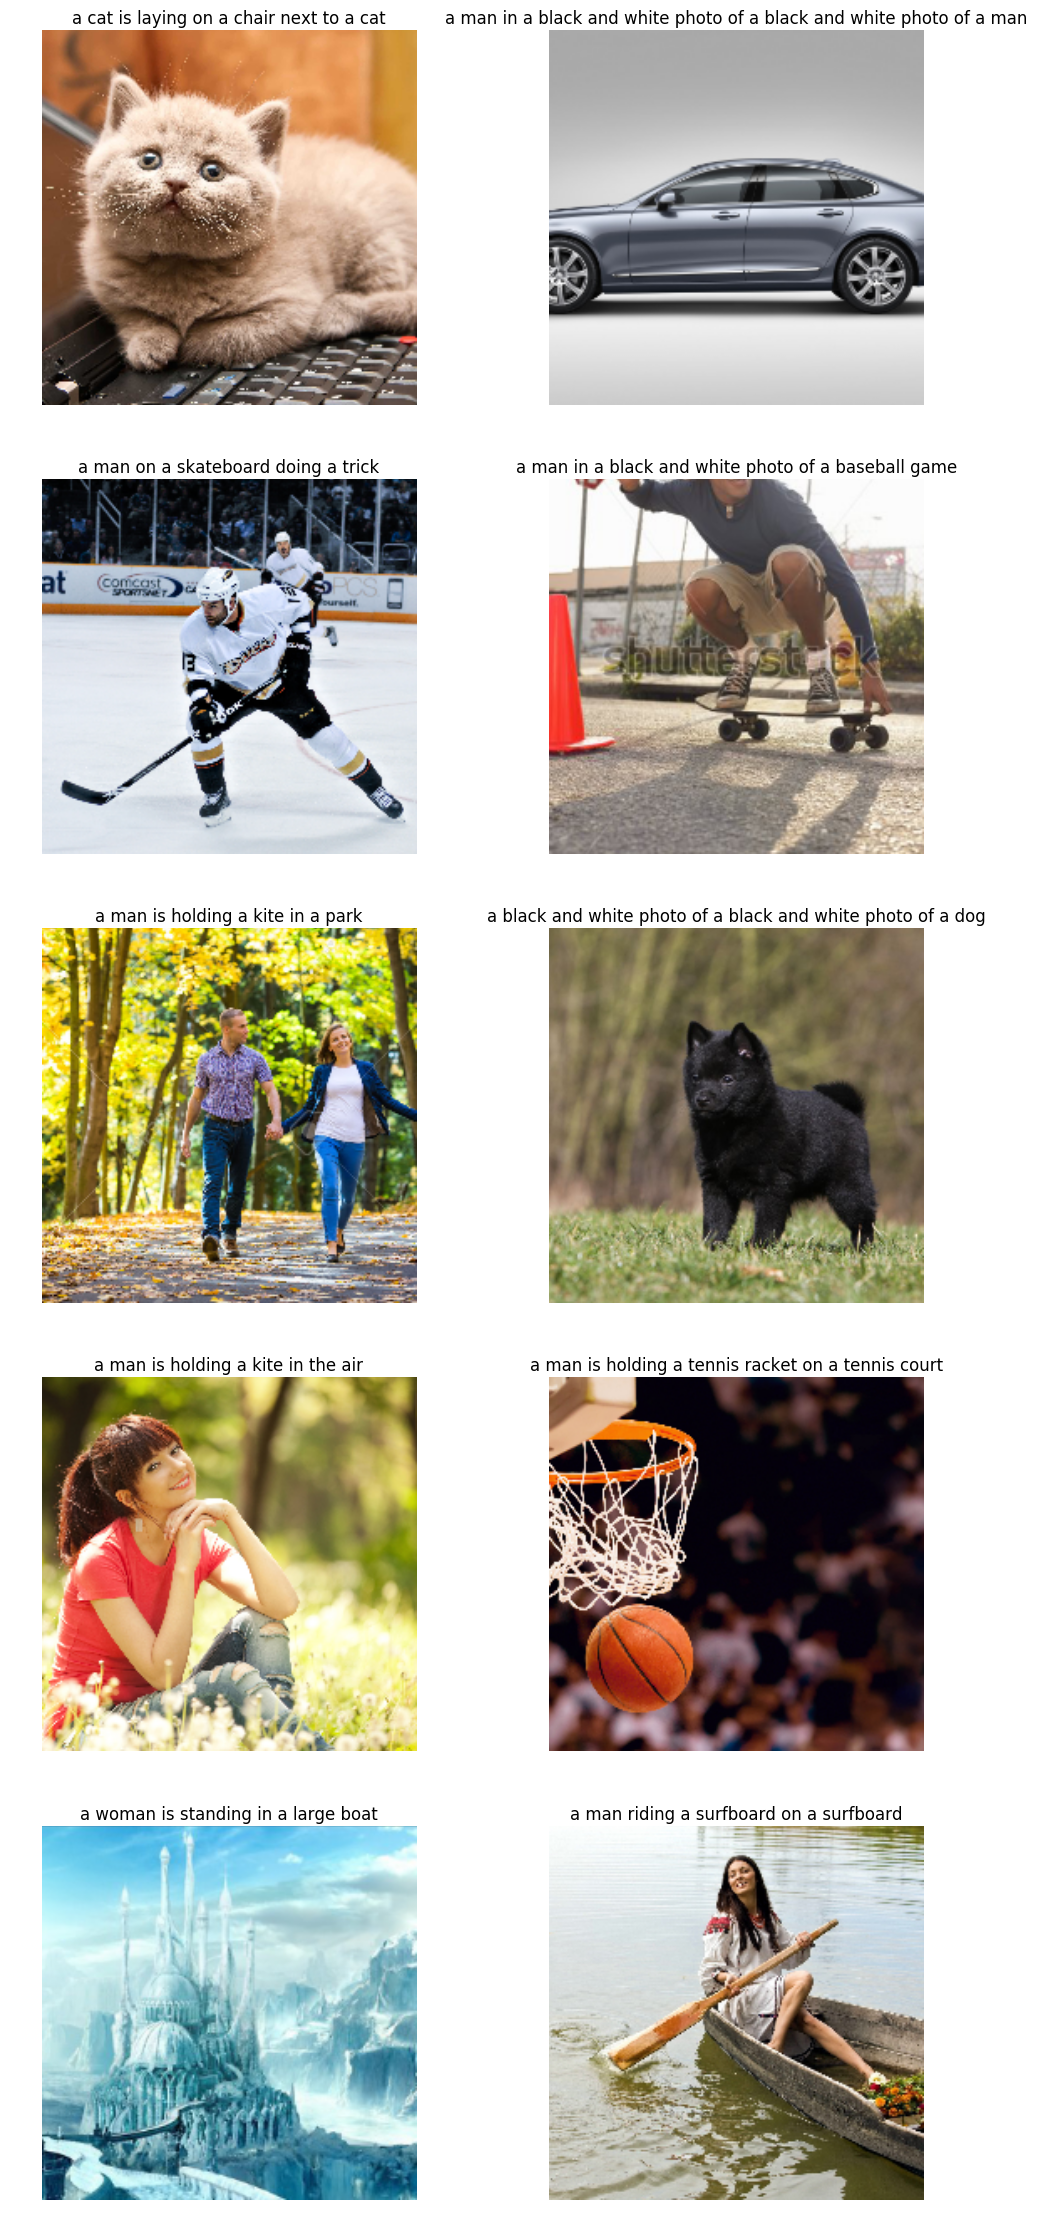

In [208]:
plt.figure(figsize=(12,28))
for i in range(10):
    img = plt.imread('fail/img'+str(i+1)+'.jpg')
    img = preprocess(img)
    txt = ' '.join(generate_caption(img,t=5.,sample=False)[1:-1])
    plt.subplot(5,2,i+1)
    plt.axis('off')
    plt.title(txt)
    plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

# grading

* base 5 if it compiles and trains without exploding
* +1 for finding representative set of reference examples
* +2 for providing 10+ examples where network provides reasonable captions (at least sometimes :) )
  * you may want to predict with sample=False and deterministic=True for consistent results
  * kudos for submitting network params that reproduce it
* +2 for providing 10+ examples where network fails IF you also got previous 10 examples right


* bonus points for experiments with architecture and initialization (see above)
* bonus points for trying out other pre-trained nets for captioning
* a whole lot of bonus points if you also train via metric learning
 * image -> vec
 * caption -> vec (encoder, not decoder)
 * loss = correct captions must be closer, wrong ones must be farther
 * prediction = choose caption that is closest to image
* a freaking whole lot of points if you also obtain statistically signifficant results the other way round
 * take caption, get closest image